# Basic imports
---

In [5]:
# TODO: Add the necessary modules
import os, glob, random, shutil, csv
import numpy as np
import pandas as pd
from pandas.core.common import flatten
import matplotlib.pyplot as plt
import cv2
import math
from PIL import Image

%matplotlib inline

import torch
import torch.nn.functional as F
from torch import optim, nn, utils, Tensor
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split

import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchmetrics
import torchvision.models as models


import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger

from dotenv import load_dotenv
load_dotenv()

torch.set_printoptions(threshold=float('inf'))


# Download and process the data set
---



## Download from github

In [6]:
!git clone https://github.com/octavio-navarro/DL_Data_sets.git

fatal: destination path 'DL_Data_sets' already exists and is not an empty directory.


## Show an image from the data set

(30, 30, 3)


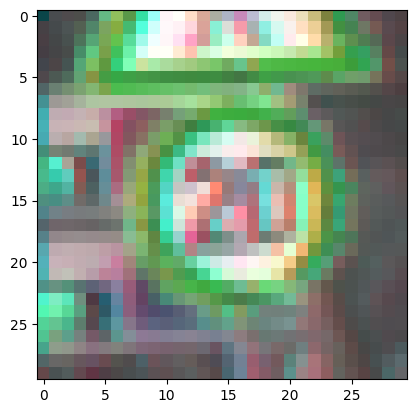

In [7]:
# TODO: Plot an image from the dataset using matplotlib
base_path = os.getenv("COMP_VISION_PATH")

img_path = os.path.join(
    base_path,
    "DL_Data_sets",
    "German_Traffic_signs",
    "Images",
    "00000",
    "00000_00001.ppm"
)

image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
print(image.shape)
plt.imshow(image)

## Separates the data into different folders

In [8]:
# TODO: Check out glob and copyfile, and create the test and train folders as needed. Each of the folders must have folders for each of the categories.
def separate_data(base_path, signal_dir, split_ratio=0.85):

    # Get complete signal directory path
    complete_signal_dir = os.path.join(base_path, signal_dir)

    # Iterate though each image
    file_names = []
    for root, _, files in os.walk(complete_signal_dir):
        for file in files:
            if file.endswith('.ppm'):
                file_names.append(os.path.join(root, file))

    # Shuffle the file names
    random.shuffle(file_names)

    # Split train and test sets
    split_idx = int(len(file_names) * split_ratio)
    train_images = file_names[:split_idx]
    test_images = file_names[split_idx:]

    train_labels = [signal_dir] * len(train_images)
    test_labels  = [signal_dir] * len(test_images)


    return train_images, test_images, train_labels, test_labels

"""
=================================
Generate train and test sets
=================================
"""

base_path = os.getenv("COMP_VISION_PATH")

imgs_path = os.path.join(
    base_path,
    "DL_Data_sets",
    "German_Traffic_signs",
    "Images"
)

split_ratio = 0.85
train_images = []
test_images = []
train_labels = []
test_labels = []
classes = os.listdir(imgs_path)

# Iterate through each class directory
for class_ in classes:
    # Separate data for the current class in train and test sets
    class_train, class_test, class_train_label, classs_test_label  = separate_data(imgs_path, signal_dir=class_, split_ratio=split_ratio)
    # Append to the overall train and test lists
    train_images.extend(class_train)
    test_images.extend(class_test)
    train_labels.extend(class_train_label)
    test_labels.extend(classs_test_label)


In [9]:
unique_names = list(dict.fromkeys(classes))
y = [unique_names.index(name) for name in classes]
# get unique names in order of appearance

# map each name to its index
y = [unique_names.index(name) for name in classes]

print(y)

num_classes = max(y) + 1
one_hot_labels = F.one_hot(torch.tensor(y), num_classes=num_classes).float()

print("Número de clases:", num_classes)
print("Lista de clases:", len(classes))
print("OHE Shape:", one_hot_labels.shape)
print("OHE Values:", one_hot_labels)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42]
Número de clases: 43
Lista de clases: 43
OHE Shape: torch.Size([43, 43])
OHE Values: tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

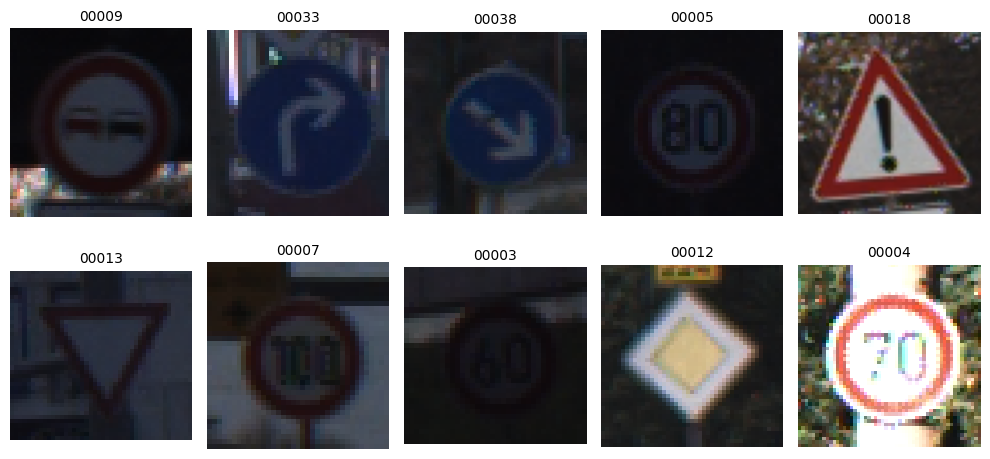

In [10]:
# Print 10 random train images with their class extracted from the file path
num_images = 10
selected = random.sample(train_images, num_images)  # elige 10 sin repetir

fig, axes = plt.subplots(2, 5, figsize=(10,5))
axes = axes.flatten()

for i, ax in enumerate(axes):
    img_path = selected[i]
    img_class = os.path.basename(os.path.dirname(img_path))

    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    ax.imshow(image)
    ax.set_title(img_class, fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

# Model definition with transfer learning
---

## Define a model to classify the images. **Use transfer learning for this step, but don't use fine-tuning.**


In [11]:
# TODO: Define a model to classify the images.
resnet_model = models.resnet152(weights=None)
in_features = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(in_features, num_classes)

class CnnModel(L.LightningModule):
    def __init__(self, model, learning_rate, num_classes):
        """Initialize the CIFARCnnModel class.

            Args:
                model (torch.nn.Module): The CNN model to be used for training and inference.
                learning_rate (float): The learning rate for the optimizer.
        """
        super().__init__()

        self.learning_rate = learning_rate
        self.model = model

        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x):
        """Forward pass of the model.

            Args:
                x (torch.Tensor): Input tensor of shape (batch_size, 1, 28, 28)

            Returns:
                torch.Tensor: Output tensor after passing through the model
        """
        return self.model(x)

    def _shared_step(self, batch):
        features, true_labels_ohe = batch          # [B, num_classes]

        true_labels = true_labels_ohe.argmax(dim=1)   # [B]

        logits = self(features)                       # [B, num_classes]

        loss = F.cross_entropy(logits, true_labels)

        return loss, logits, true_labels


    def training_step(self, batch, batch_idx):
        """Perform a training step.

            Args:
                batch: A batch of training data containing features and labels.
                batch_idx (int): Index of the current batch in the epoch.

            Returns:
                torch.Tensor: Loss tensor to be optimized
        """
        loss, logits, true_labels = self._shared_step(batch)

        self.log("train_loss", loss)
        self.train_acc(logits, true_labels)
        self.log("train_acc", self.train_acc, prog_bar=True, on_epoch=True, on_step=False)
        return loss


    def validation_step(self, batch, batch_idx):
        """Perform a validation step.

            Args:
                batch: A batch of validation data containing features and labels.
                batch_idx (int): Index of the current batch in the validation set.

            Returns:
                torch.Tensor: Validation loss tensor
        """
        loss, logits, true_labels = self._shared_step(batch)

        self.log("val_loss", loss, prog_bar=True)
        self.val_acc(logits, true_labels)
        self.log("val_acc", self.val_acc, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        with torch.no_grad():
            loss, logits, true_labels = self._shared_step(batch)
            self.test_acc(logits, true_labels)
            self.log("test_acc", self.test_acc)


    def configure_optimizers(self):
        """Configure the optimizer for training.

            Returns:
                torch.optim.Optimizer: Optimizer for training
        """
        optimizer = torch.optim.RMSprop(self.parameters(), lr=self.learning_rate)
        return optimizer

## Define the data augmentation transformations for the data loaders.

In [12]:
# TODO: Add data augmentation

image_transforms = transforms.Compose([

        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.2),
        transforms.RandomRotation(45/2),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),

])

## Define the train, validation, and test dataloaders

In [13]:
# TODO: Create generators for training, validation, and testing.

class SignalsDatasets(Dataset):
    def __init__(self, file_dir, classes, ohe, transform=None):
        self.labels_df = file_dir
        self.transform = transform
        self.classes = classes
        self.one_hot_encoding = ohe

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_path = self.labels_df[idx]
        image = Image.open(img_path)

        i = self.get_class(self.classes[idx])
        label = self.one_hot_encoding[i]

        if self.transform:
            image = self.transform(image)

        return image, label

    def get_class(self, curr_class):
        a = curr_class[-2]
        b = curr_class[-1]

        return int(a) * 10 + int(b)


train_dataset = SignalsDatasets(train_images, train_labels, one_hot_labels, transform=image_transforms)
train_dataset, val_dataset = random_split(train_dataset, lengths=[len(train_images) - len(test_images), len(test_images)])

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=25)

print(f'Training dataset: {len(train_dataset)}')
print(f'Validation dataset: {len(val_dataset)}')

print(f'Classes: {train_dataset.dataset.classes[0]}')
print(f'Classes: {len(train_dataset.dataset.classes)}')
print(f'Transform: {train_dataset.dataset.transform}')

Training dataset: 27427
Validation dataset: 5891
Classes: 00000
Classes: 33318
Transform: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.2)
    RandomRotation(degrees=[-22.5, 22.5], interpolation=nearest, expand=False, fill=0)
    ColorJitter(brightness=(0.9, 1.1), contrast=(0.9, 1.1), saturation=(0.9, 1.1), hue=(-0.1, 0.1))
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)


## Using matplotlib, visualize images from the train dataloader. Create a figure of 20 images, with 5 images per row.

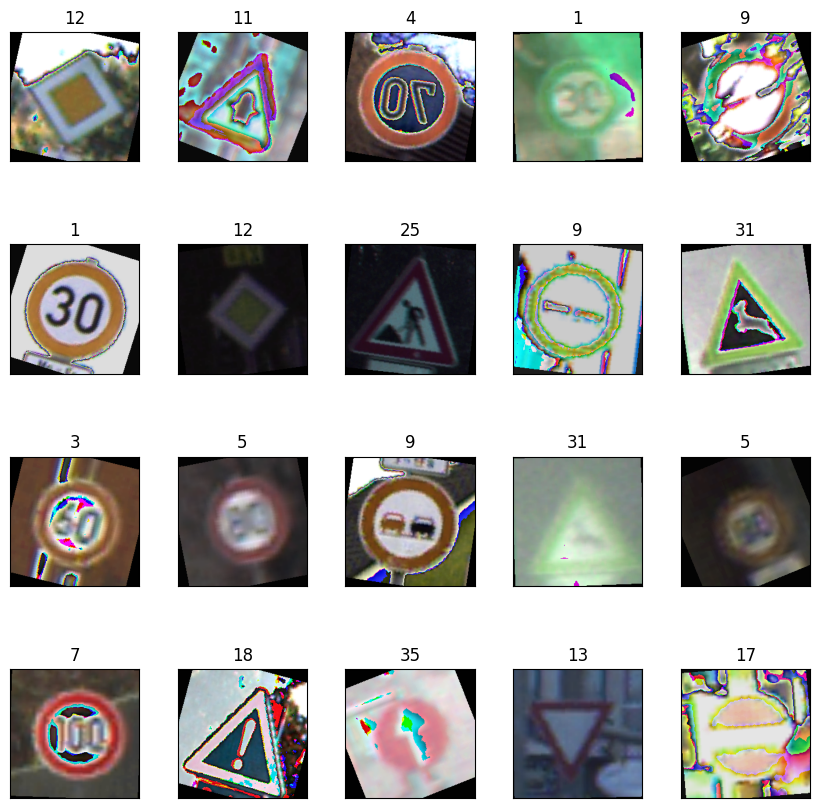

In [14]:
# TODO: Create a figure with images from the test generator.
train_batch = next(iter(train_dataloader))

f, ax = plt.subplots(4, 5, figsize=(10, 10))
f.tight_layout(pad=0.)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.3, hspace=0.3)

for idx in range(20):
    row = idx // 5
    col = idx % 5

    image = train_batch[0][idx].numpy().transpose((1, 2, 0))
    image = (image * 255.0).astype("uint8")

    label_tensor = train_batch[1][idx]
    label_idx = label_tensor.argmax().item()


    ax[row, col].imshow(image)
    ax[row, col].set_title(label_idx)
    ax[row, col].set_xticks([])
    ax[row, col].set_yticks([])

plt.show()

## Train the model. Use model checkpoints and early stopping during training. **Don't forget to use a GPU for training.**

In [15]:
# TODO: Train the model.

signalModel = CnnModel(model=resnet_model, learning_rate=1e-4, num_classes = num_classes)

checkpoint = ModelCheckpoint(
    dirpath="checkpoints/",
    filename="gtsrb",
    save_top_k=1,
    monitor="val_loss",
    mode="min"
)

trainer_cnn = L.Trainer(
    accelerator="gpu",
    max_epochs=15,
    logger=CSVLogger(save_dir="logs/", name="signalModel"),
    callbacks=[checkpoint]
)


trainer_cnn.fit(
        model=signalModel,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader,
    )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | ResNet             | 58.2 M | train
1 | train_acc | MulticlassAccuracy | 0      | train
2 | val_acc   | MulticlassAccuracy | 0      | train
3 | test_acc  | MulticlassAccuracy | 0      | train
---------------------------------------------------------
58.2 M    Trainable params
0         Non-trainable params
58.2 M    Total params
232.928   Total estimated model params size (MB)
426    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

f:\TEC\Septimo\TC3007C\gpuenv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


f:\TEC\Septimo\TC3007C\gpuenv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 14: 100%|██████████| 858/858 [06:55<00:00,  2.06it/s, v_num=0, val_loss=0.0491, val_acc=0.985, train_acc=0.988]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 858/858 [06:55<00:00,  2.06it/s, v_num=0, val_loss=0.0491, val_acc=0.985, train_acc=0.988]


## Model evaluation
---

### Evaluate the performance of the model with the test dataloader.

In [16]:
def compute_accuracy(model, dataloader, device=None):
    """Compute the accuracy of the model on the given dataloader."""
    if device is None:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model = model.to(device)
    model.eval()

    correct = 0
    total_examples = 0

    with torch.no_grad():
        for features, labels_ohe in dataloader:
            features = features.to(device)
            labels_ohe = labels_ohe.to(device)


            labels = labels_ohe.argmax(dim=1)

            logits = model(features)
            predictions = torch.argmax(logits, dim=1)

            compare = (labels == predictions)
            correct += compare.sum().item()
            total_examples += labels.size(0)

    return correct / total_examples


In [17]:
test_dataset = SignalsDatasets(test_images, test_labels, one_hot_labels, transform=image_transforms)
test_dataloader = DataLoader(test_dataset, batch_size=25, shuffle=True)

In [18]:
train_acc = compute_accuracy(signalModel, train_dataloader, device = torch.device('cuda'))
val_acc = compute_accuracy(signalModel, val_dataloader, device = torch.device('cuda'))
test_acc = compute_accuracy(signalModel, test_dataloader, device = torch.device('cuda'))
print(
    f"Train Acc {train_acc*100:.2f}%",
    f" | Val Acc {val_acc*100:.2f}%",
    f" | Test Acc {test_acc*100:.2f}%"
)

Train Acc 98.83%  | Val Acc 98.68%  | Test Acc 98.39%


### Plot the results of training: plot training and validation accuracy, and loss.

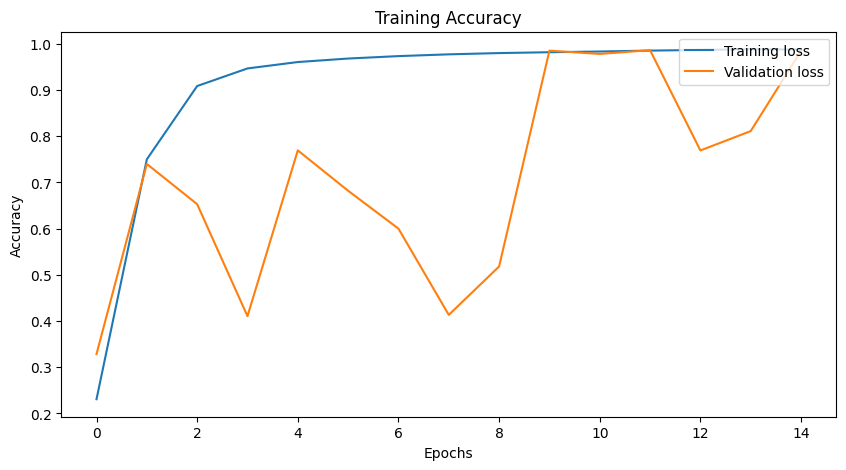

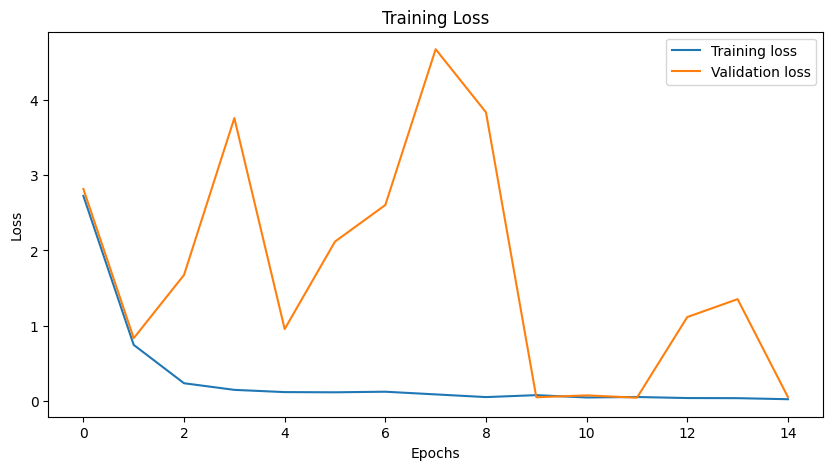

In [19]:
# Read the metrics.csv file generated by the PyTorch Lightning logger
metrics = pd.read_csv(f"{trainer_cnn.logger.log_dir}/metrics.csv")
# Group the metrics by epoch and compute the mean loss for each epoch
df_epochs = metrics.groupby('epoch').mean()

# TODO: Plot the results of the training and validation accuracy.

# Create a figure and axis for plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# Set the x-axis label
ax.set_xlabel('Epochs')
# Set the y-axis label
ax.set_ylabel('Accuracy')
# Plot the training loss over epochs
ax.plot(df_epochs['train_acc'], label="Training loss")
# Plot the validation loss over epochs
ax.plot(df_epochs['val_acc'], label="Validation loss")
# Set the title of the plot
ax.set_title("Training Accuracy")
# Add a legend to the plot
ax.legend(loc='upper right')

# TODO: Plot the results of the training and validation loss.


# Create a figure and axis for plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# Set the x-axis label
ax.set_xlabel('Epochs')
# Set the y-axis label
ax.set_ylabel('Loss')
# Plot the training loss over epochs
ax.plot(df_epochs['train_loss'], label="Training loss")
# Plot the validation loss over epochs
ax.plot(df_epochs['val_loss'], label="Validation loss")
# Set the title of the plot
ax.set_title("Training Loss")
# Add a legend to the plot
ax.legend(loc='upper right')

# Model using Transfer Learning and fine-tuning
---

Create a model using transfer learning, data augmentation, and fine-tuning, train the model, and do predictions with it on the test dataset.

## Make and train a new model using transfer learning and fine-tuning.


In [20]:
# TODO: Create a model using transfer learning
resnet_model_ft = models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V1)

# reemplazar la última capa por una del tamaño de tu problema
in_features = resnet_model_ft.fc.in_features
resnet_model_ft.fc = nn.Linear(in_features, num_classes)

for param in resnet_model_ft.parameters():
    param.requires_grad = False  # congelar todo

# solo la fc nueva se entrena
for param in resnet_model_ft.fc.parameters():
    param.requires_grad = True

train_dataset = SignalsDatasets(train_images, train_labels, one_hot_labels, transform=image_transforms)
train_dataset, val_dataset = random_split(train_dataset, lengths=[len(train_images) - len(test_images), len(test_images)])

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=25)

train_batch = next(iter(train_dataloader))

signalModel_ft = CnnModel(model=resnet_model_ft, learning_rate=1e-4, num_classes = num_classes)

checkpoint_ft = ModelCheckpoint(
    dirpath="checkpoints/",
    filename="gtsrb_finetuned",
    save_top_k=1,
    monitor="val_loss",
    mode="min"
)

trainer_cnn_ft = L.Trainer(
    accelerator="gpu",
    max_epochs=15,
    logger=CSVLogger(save_dir="logs/", name="signalModel(FineTunning)"),
    callbacks=[checkpoint_ft]
)

trainer_cnn_ft.fit(
        model=signalModel_ft,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader,
    )

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to C:\Users\calvo/.cache\torch\hub\checkpoints\resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:56<00:00, 4.26MB/s] 
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
f:\TEC\Septimo\TC3007C\gpuenv\Lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:751: Checkpoint directory F:\TEC\Septimo\TC3007C\ComputerVision\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | ResNet             | 58.2 M | train
1 | train_acc | MulticlassAccuracy | 0      | train
2 | val_acc   | MulticlassAccuracy | 0      | train
3 | test_acc  | MulticlassAccuracy | 0      | train
---------------------------------------------------------
88.1 K    Trainable params
58.1 M    Non-trainable params
58.2 M    Total params
232.928   Total estimated m

Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00, 27.41it/s]

f:\TEC\Septimo\TC3007C\gpuenv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


f:\TEC\Septimo\TC3007C\gpuenv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 14: 100%|██████████| 858/858 [03:00<00:00,  4.76it/s, v_num=0, val_loss=0.898, val_acc=0.717, train_acc=0.724]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 858/858 [03:01<00:00,  4.73it/s, v_num=0, val_loss=0.898, val_acc=0.717, train_acc=0.724]


## Plot the results of training and evaluation

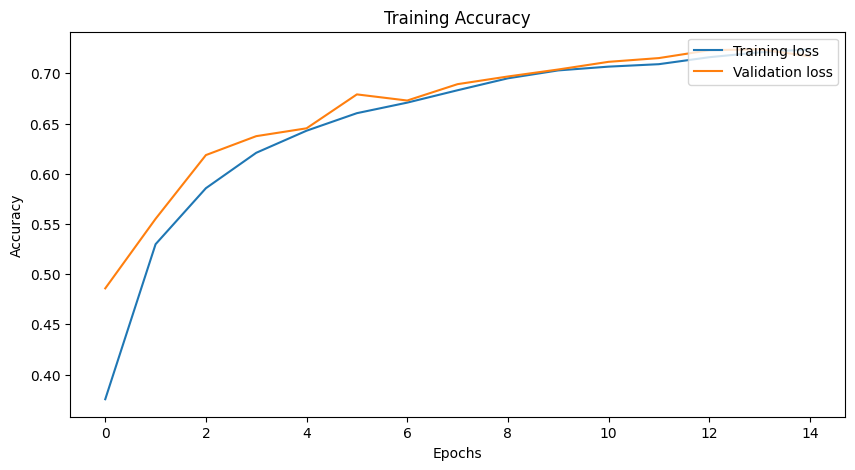

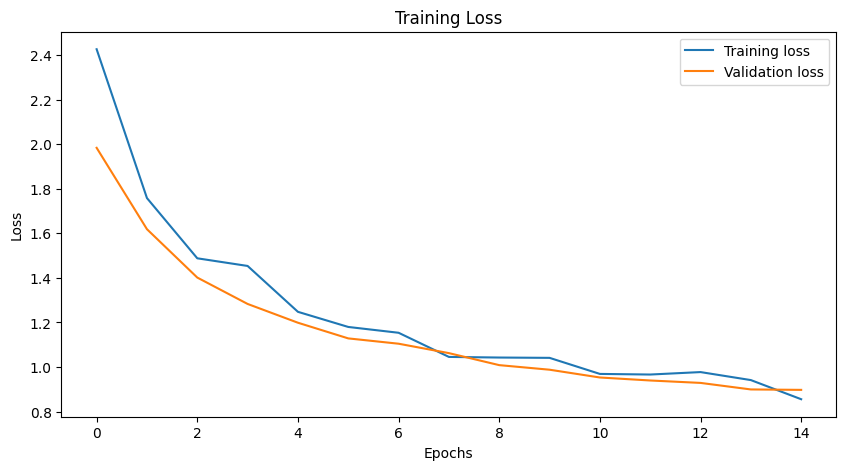

In [21]:
# TODO: Plot training and print the evaluation results
# Read the metrics.csv file generated by the PyTorch Lightning logger
metrics = pd.read_csv(f"{trainer_cnn_ft.logger.log_dir}/metrics.csv")
# Group the metrics by epoch and compute the mean loss for each epoch
df_epochs = metrics.groupby('epoch').mean()

# TODO: Plot the results of the training and validation accuracy.

# Create a figure and axis for plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# Set the x-axis label
ax.set_xlabel('Epochs')
# Set the y-axis label
ax.set_ylabel('Accuracy')
# Plot the training loss over epochs
ax.plot(df_epochs['train_acc'], label="Training loss")
# Plot the validation loss over epochs
ax.plot(df_epochs['val_acc'], label="Validation loss")
# Set the title of the plot
ax.set_title("Training Accuracy")
# Add a legend to the plot
ax.legend(loc='upper right')

# TODO: Plot the results of the training and validation loss.


# Create a figure and axis for plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# Set the x-axis label
ax.set_xlabel('Epochs')
# Set the y-axis label
ax.set_ylabel('Loss')
# Plot the training loss over epochs
ax.plot(df_epochs['train_loss'], label="Training loss")
# Plot the validation loss over epochs
ax.plot(df_epochs['val_loss'], label="Validation loss")
# Set the title of the plot
ax.set_title("Training Loss")
# Add a legend to the plot
ax.legend(loc='upper right')

## Makes predictions using the test dataset

In [22]:
# TODO: Make predictions

test_dataset = SignalsDatasets(test_images, test_labels, one_hot_labels, transform=image_transforms)
test_dataloader = DataLoader(test_dataset, batch_size=25, shuffle=True)

train_acc = compute_accuracy(signalModel_ft, train_dataloader, device = torch.device('cuda'))
val_acc = compute_accuracy(signalModel_ft, val_dataloader, device = torch.device('cuda'))
test_acc = compute_accuracy(signalModel_ft, test_dataloader, device = torch.device('cuda'))
print(
    f"Train Acc {train_acc*100:.2f}%",
    f" | Val Acc {val_acc*100:.2f}%",
    f" | Test Acc {test_acc*100:.2f}%"
)

Train Acc 73.14%  | Val Acc 71.40%  | Test Acc 71.99%


# Compare the performance of both models
---

Plot the results of both models in the same figure.

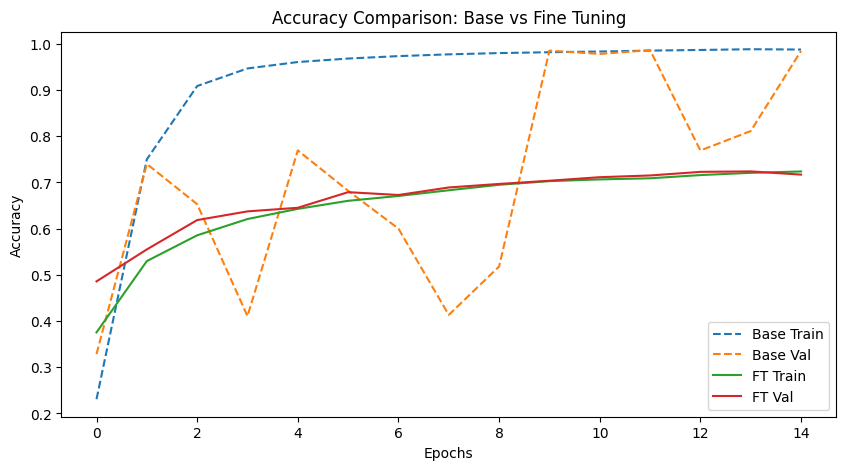

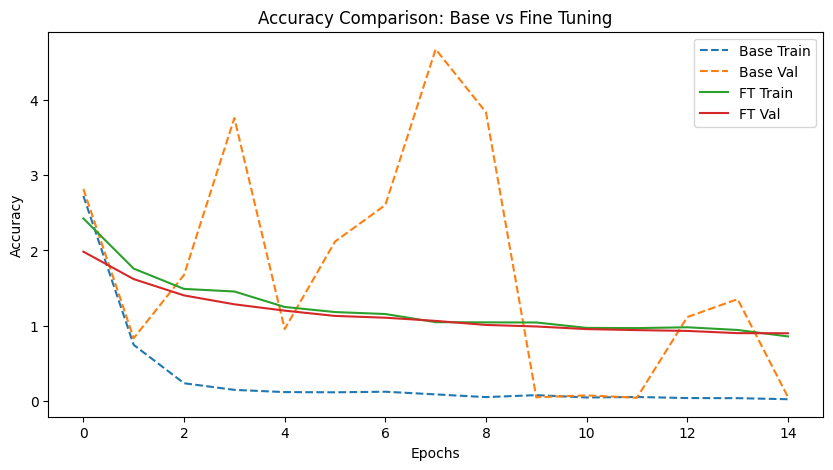

In [23]:
# TODO: Plot the results of both datasets in the same figure.

# Read the metrics.csv file generated by the PyTorch Lightning logger
metrics_base = pd.read_csv(f"{trainer_cnn.logger.log_dir}/metrics.csv")
metrics_ft   = pd.read_csv(f"{trainer_cnn_ft.logger.log_dir}/metrics.csv")

df_base = metrics_base.groupby("epoch").mean()
df_ft   = metrics_ft.groupby("epoch").mean()


# TODO: Plot the results of the training and validation accuracy.

# Create a figure and axis for plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")

# BASE model
ax.plot(df_base["train_acc"], label="Base Train", linestyle="--")
ax.plot(df_base["val_acc"],   label="Base Val",   linestyle="--")

# FINE TUNING model
ax.plot(df_ft["train_acc"], label="FT Train")
ax.plot(df_ft["val_acc"],   label="FT Val")

ax.set_title("Accuracy Comparison: Base vs Fine Tuning")
ax.legend()
plt.show()

# TODO: Plot the results of the training and validation accuracy.

# Create a figure and axis for plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")

# BASE model
ax.plot(df_base["train_loss"], label="Base Train", linestyle="--")
ax.plot(df_base["val_loss"],   label="Base Val",   linestyle="--")

# FINE TUNING model
ax.plot(df_ft["train_loss"], label="FT Train")
ax.plot(df_ft["val_loss"],   label="FT Val")

ax.set_title("Accuracy Comparison: Base vs Fine Tuning")
ax.legend()
plt.show()


# Test the models on new images
---

Download new images of traffic signs, and test both models on the images. Download at least 5 images. Plot them with the predicted class.

Add a text cell with your conclusions on the performance of the models on the new images.

## Download new images, and make predictions on them.

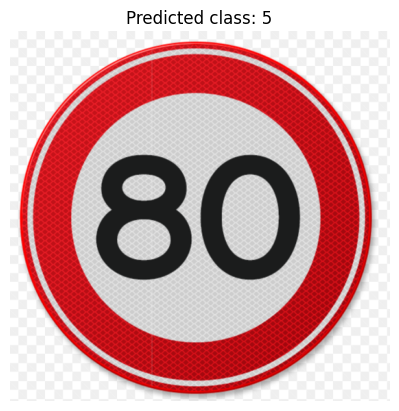

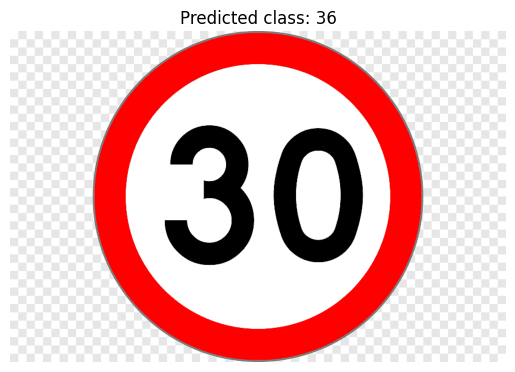

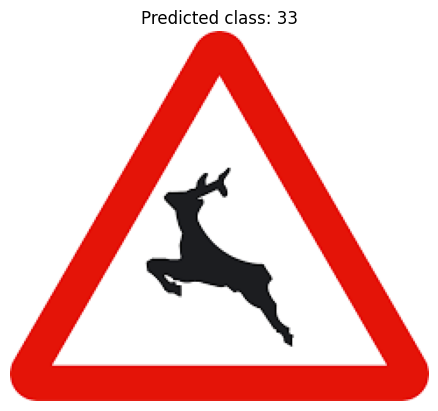

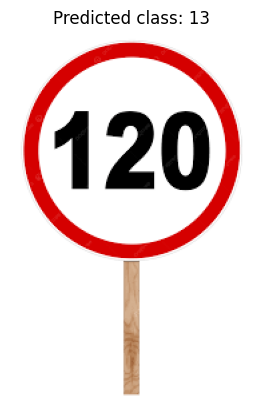

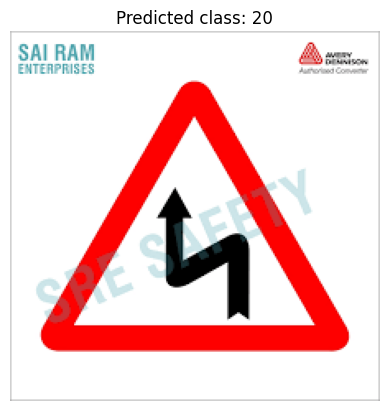

In [25]:
# TODO: Make predictions on new images.


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ckpt_path = os.path.join(
    base_path,
    "checkpoints",
    "gtsrb.ckpt"
)

model = CnnModel.load_from_checkpoint(
    ckpt_path,
    model=resnet_model,
    learning_rate=1e-4,
    num_classes=num_classes,
)

model.to(device)
model.eval()

image1 = os.path.join(base_path,"TrafficEjPhotos","image.png")
image2 = os.path.join(base_path,"TrafficEjPhotos","image2.png")
image3 = os.path.join(base_path,"TrafficEjPhotos","image3.png")
image4 = os.path.join(base_path,"TrafficEjPhotos","image4.png")
image5 = os.path.join(base_path,"TrafficEjPhotos","image5.png")

ej_images = [image1,image2,image3,image4,image5]

for image in ej_images:
    img_bgr = cv2.imread(image)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    img_pil = Image.fromarray(img_rgb)

    x = image_transforms(img_pil).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(x)
        pred = torch.argmax(logits, dim=1).item()

    plt.imshow(img_rgb)
    plt.title(f"Predicted class: {pred}")
    plt.axis("off")
    plt.show()


## Conclusión

Los resultados obtenidos en las pruebas con imágenes nuevas no fueron tan buenos como se esperaba, y es muy probable que esto se deba a varios factores que afectan directamente la capacidad del modelo para generalizar. En primer lugar, las imágenes PNG que se usaron como entrada contienen zonas “sin fondo” que se ven con los bloques de gris y blancos que generan ruido significativo cuando son convertidas a RGB. Ese tipo de irregularidades no aparece en el dataset original de entrenamiento, por lo que el modelo no aprendió a manejarlas y termina interpretando esos píxeles como patrones que no corresponden a ninguna clase real.

Además, las imágenes de prueba tienen tamaños, proporciones y resoluciones distintas a las del dataset original. Aunque las transformaciones intentan normalizar estas diferencias, los cambios bruscos en escalado y composición visual alteran la forma de los signos y pueden llevar a que el modelo identifique características que no coinciden con lo aprendido durante el entrenamiento.

Aparte de que para nuestras pruebas se usaron las señales de limites de velocidad que son muy similares entre sí.